# Advanced Machine Learning

### Assigment #7 - Time Series

**Team:**
    João Raimundo (57454), Rui Roque (57588)

### 0.1 Import Libraries

In [67]:
import math
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
from IPython.display import Image


#from datetime import datetime

# tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
#from tensorflow.keras.models import Model

## 0.2 Defining functions for each model

In this stage we create a functions for the LSTM and FTLFN Models. <p>
In the functions we create the model, fit with the trainning data and the evaluation of the obtained results.

### 0.2.1. LSTM Model (Long short-term memory):

In [68]:
def lstm(X_train, y_train, X_test, y_test, epochs, noise = False, noise_value = 0.05):
    
    # model creation: layers + dropout + 12 neurons
    if(noise == False):
        lstm_model = Sequential([
        layers.LSTM(12, return_sequences=True),
        layers.Dropout(0.2),
        layers.LSTM(12, return_sequences=True),
        layers.Dropout(0.2),
        layers.LSTM(12),
        layers.Dropout(0.2),
        layers.Dense(1)
        ])
    else:
        lstm_model = Sequential([
        layers.GaussianNoise(noise_value),
        layers.LSTM(12, return_sequences=True),
        layers.Dropout(0.2),
        layers.LSTM(12, return_sequences=True),
        layers.Dropout(0.2),
        layers.LSTM(12),
        layers.Dropout(0.2),
        layers.Dense(1)
        ])    


    # compile
    lstm_model.compile(optimizer = 'adam', loss = keras.losses.MeanSquaredError(), metrics=[tf.metrics.MeanAbsoluteError()])

    print("LSTM Model contructed with 3 hidden layers of 12 neurons:\n")

    # Fitting the RNN to the Training set
    print("Currently fitting the model with the training set with", epochs, " epochs:")
    history_lstm = lstm_model.fit(X_train,y_train,epochs = epochs)

    print("\n")

    # plot loss plot
    plt.plot(history_lstm.history['loss'], label="loss")
    plt.legend(loc="upper right")
    plt.title("Loss Plot")
    plt.show()

    # inferring MSE % RMSE
    predictions = lstm_model.predict(X_test)
    test_score = mean_squared_error(y_test, predictions)
    print('LSTM Model Test MSE: %.3f' % test_score)
    print('LSTM Model Test RMSE: %.3f' % sqrt(test_score))

    # plot predictions and expected results
    fig = plt.figure(figsize=(40,10))
    plt.plot(y_train,  label="Train")
    plt.plot([None for i in y_train] + [x for x in y_test], label="Test")
    plt.plot([None for i in y_train] + [x for x in predictions], label="Predicted")
    plt.legend(loc="upper left", prop= {"size": 15}) 
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.title("Train, Test and Predicted Results")
    plt.show()


### 0.2.2. FTLFN Model:

In [69]:
def ftlfn(X_train, y_train, X_test, y_test, epochs, noise = False, noise_value = 0.05):

    # model creation: layers + dropout + 12 neurons
    if(noise == False):
        ftlfn_model = Sequential([
        layers.Dense(12, activation='relu'),
        layers.Dense(1)
        ])
    else:
        ftlfn_model = Sequential([
        layers.GaussianNoise(noise_value),
        layers.Dense(12, activation='relu'),
        layers.Dense(1)
        ])


    # compile
    ftlfn_model.compile(optimizer = 'adam', loss = keras.losses.MeanSquaredError(), metrics=[tf.metrics.MeanAbsoluteError()])

    # Fitting the RNN to the Training set
    print("Currently fitting the model with the training set with", epochs, " epochs:")

    train_performance, test_performance = list(), list()
    
    for i in range(epochs):
        history_ftlfn = ftlfn_model.fit(X_train,y_train,epochs = 1)
        
        train_performance.append(ftlfn_model.evaluate(X_train, y_train, verbose=0)[0])
        test_performance.append(ftlfn_model.evaluate(X_test_1, y_test_1, verbose = 0)[0])

    performance = pd.DataFrame()
    performance["train_mse"], performance["test_mse"] = train_performance, test_performance

    return performance
    

In [70]:
def run_ftlfn(X_train, y_train, X_test, y_test, repeats, epochs, noise = False, noise_value = 0.05):
    # constructing the feedforward network
    print("FTLFN Model contructed with 12 neurons:\n")

    aux=0
    for i in range(repeats):
        history = ftlfn(X_train, y_train, X_test, y_test, epochs)
        plt.plot(history['train_mse'], color='blue', label = "Train")
        plt.plot(history['test_mse'], color='orange', label = "Test")
        if aux == 0:
            plt.title("MSE for Train and Test Sets")
            plt.legend(loc="upper left", prop= {"size": 10}) 
            aux=1
        print('Repeat %d) TrainMSE=%f, TestMSE=%f' % (i, history['train_mse'].iloc[-1], history['test_mse'].iloc[-1]),"\n")

## Problem 1

We will observe the evolution of LSTM and FTLFN models learning rate process and compare their performances with (Gaussian N(0, 0.05)) and without noise, with diferent sets of the time series data points.

 * Epochs = 10

### 1.1. Creation of the time series 

We defined a time series with a sinusoidal function with 100 periods and 50 points per period with a time delay of 12.
We subset the timeseries dataset in two distinct manners, in order to evaluate the performances when performed with each model (LSTM and FTLFN):
  * The first 2400 data points and test with data points 2401 to 2500
  * Data points 2401 to 4900 and test with data points 4901 to 5000

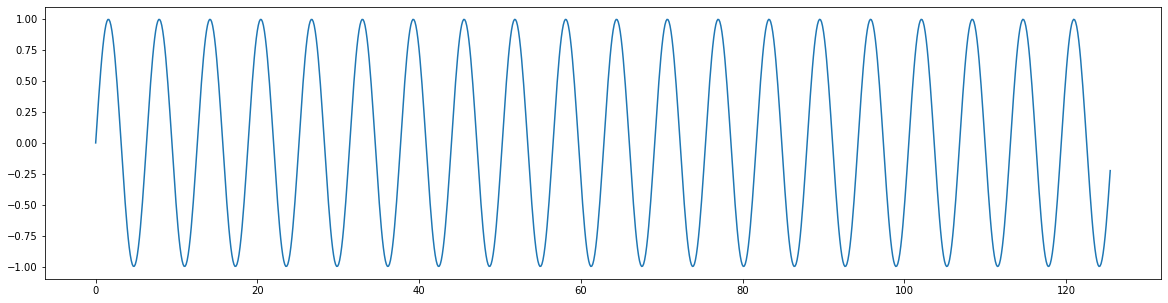

In [71]:
lag = 12
points = np.linspace(0, 2*math.pi*100, 50*100)
sin = np.sin(points)

fig = plt.figure(figsize=(20,5))


# plot the function - first 
plt.plot(points[0:999], sin[0:999])
plt.show()

Adding a filter (time delay) of 12 to the time series:

In [72]:
X = []
y = []

for i in range(lag, 4999):
   X.append(sin[i-lag:i])
   y.append(sin[i])

X = np.expand_dims(X, axis = 2)
y = np.array(y)

Split Data:

- Training with the first 2400 data points and testing with data points 2401 to 2501 (First split);
  
- Training from data points 2401 to 4900 and testing with data points 4901 to the last data point (Second split).

In [73]:
X_train_1 = X[:2400]
y_train_1 = y[:2400]
X_test_1  = X[2401:2501]
y_test_1  = y[2401:2501]

X_train_2 = X[2401:4900]
y_train_2 = y[2401:4900]
X_test_2  = X[4901:-1]
y_test_2  = y[4901:-1]

print("Shape of sets: \n")
print("--> First Split Train and Test sets:")
print("X_train_1: ", X_train_1.shape)
print("y_train_1: ", y_train_1.shape)
print("X_test_1: ", X_test_1.shape)
print("y_test_1: ", y_test_1.shape,"\n")

print("--> Second Split Train and Test sets:")
print("X_train_2: ", X_train_2.shape)
print("y_train_2: ", y_train_2.shape)
print("X_test_2: ", X_test_2.shape)
print("y_test_2: ", y_test_2.shape)

Shape of sets: 

--> First Split Train and Test sets:
X_train_1:  (2400, 12, 1)
y_train_1:  (2400,)
X_test_1:  (100, 12, 1)
y_test_1:  (100,) 

--> Second Split Train and Test sets:
X_train_2:  (2499, 12, 1)
y_train_2:  (2499,)
X_test_2:  (85, 12, 1)
y_test_2:  (85,)


 ### 1.2 Inferring the evolution of LSTM and FTLFN learning process without noise

### 1.2.1. LSTM Model

### 1.2.1.1 First split:

LSTM Model contructed with 3 hidden layers of 12 neurons:

Currently fitting the model with the training set with 10  epochs:
Epoch 1/10
75/75 [==============================] - 5s 9ms/step - loss: 0.3763 - mean_absolute_error: 0.5500
Epoch 2/10
75/75 [==============================] - 1s 8ms/step - loss: 0.1432 - mean_absolute_error: 0.3161
Epoch 3/10
75/75 [==============================] - 1s 9ms/step - loss: 0.0380 - mean_absolute_error: 0.1541
Epoch 4/10
75/75 [==============================] - 1s 10ms/step - loss: 0.0320 - mean_absolute_error: 0.1410
Epoch 5/10
75/75 [==============================] - 1s 8ms/step - loss: 0.0282 - mean_absolute_error: 0.1319
Epoch 6/10
75/75 [==============================] - 1s 9ms/step - loss: 0.0262 - mean_absolute_error: 0.1264
Epoch 7/10
75/75 [==============================] - 1s 8ms/step - loss: 0.0251 - mean_absolute_error: 0.1239
Epoch 8/10
75/75 [==============================] - 1s 8ms/step - loss: 0.0234 - mean_absolute_error: 0.1196
E

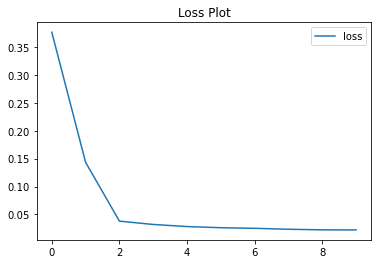

LSTM Model Test MSE: 0.002
LSTM Model Test RMSE: 0.049


c:\Users\raimu\anaconda3\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


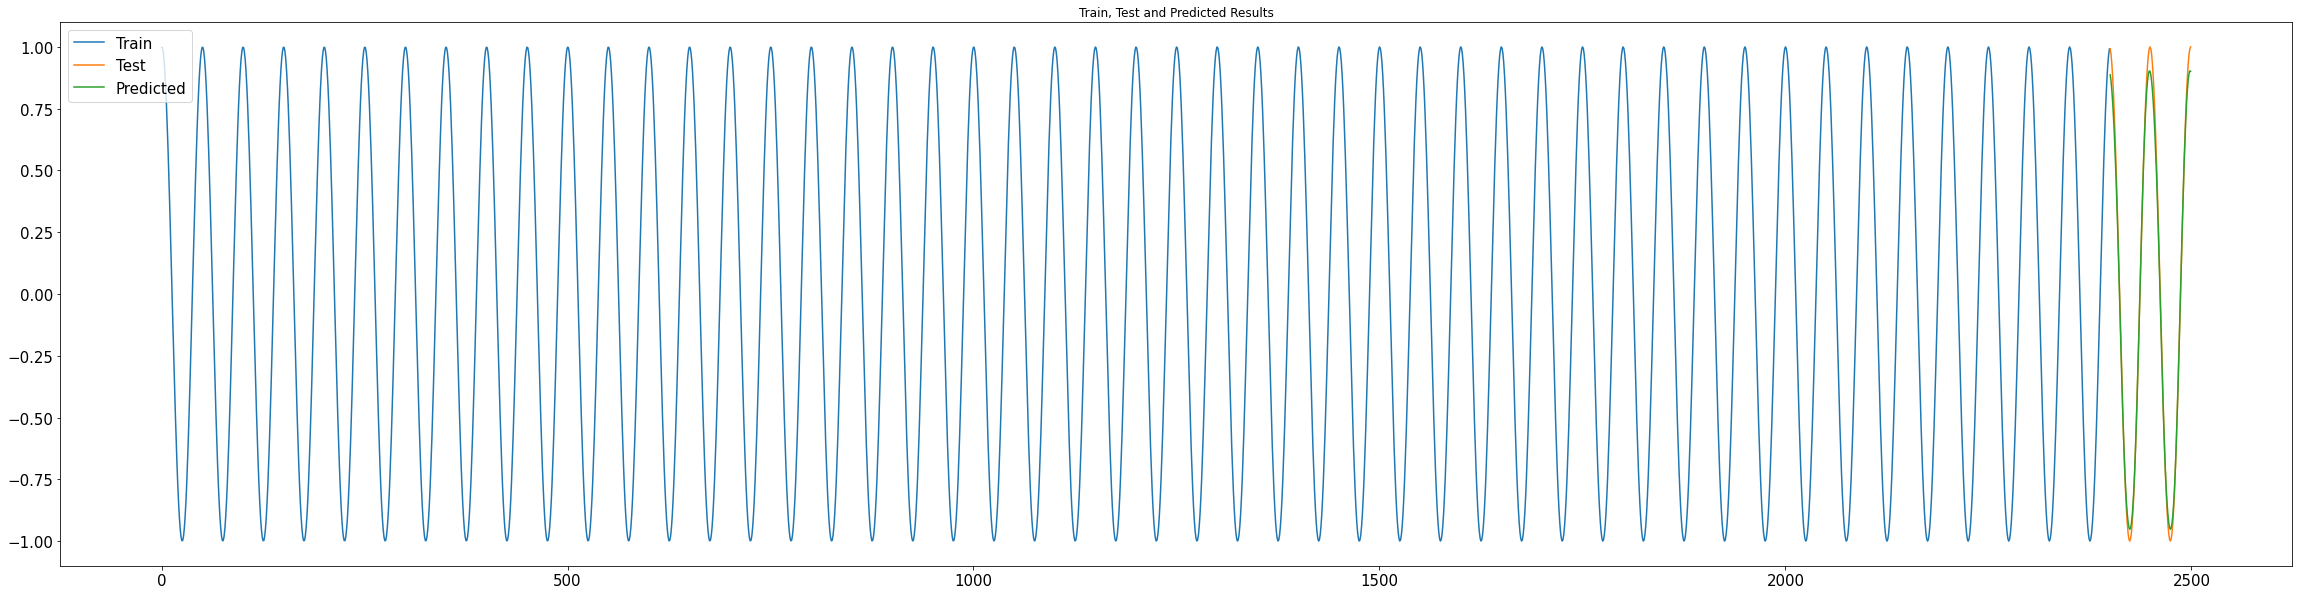

In [74]:
lstm(X_train_1, y_train_1, X_test_1, y_test_1, 10)

### 1.2.1.2 Second split:

LSTM Model contructed with 3 hidden layers of 12 neurons:

Currently fitting the model with the training set with 10  epochs:
Epoch 1/10
79/79 [==============================] - 6s 12ms/step - loss: 0.4072 - mean_absolute_error: 0.5724
Epoch 2/10
79/79 [==============================] - 1s 13ms/step - loss: 0.1394 - mean_absolute_error: 0.3050
Epoch 3/10
79/79 [==============================] - 1s 12ms/step - loss: 0.0396 - mean_absolute_error: 0.1573
Epoch 4/10
79/79 [==============================] - 1s 12ms/step - loss: 0.0347 - mean_absolute_error: 0.1480
Epoch 5/10
79/79 [==============================] - 1s 11ms/step - loss: 0.0290 - mean_absolute_error: 0.1348
Epoch 6/10
79/79 [==============================] - 1s 12ms/step - loss: 0.0279 - mean_absolute_error: 0.1297
Epoch 7/10
79/79 [==============================] - 1s 12ms/step - loss: 0.0254 - mean_absolute_error: 0.1240
Epoch 8/10
79/79 [==============================] - 1s 12ms/step - loss: 0.0232 - mean_absolute_error: 0

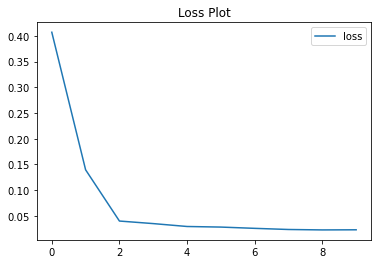

LSTM Model Test MSE: 0.001
LSTM Model Test RMSE: 0.033


c:\Users\raimu\anaconda3\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


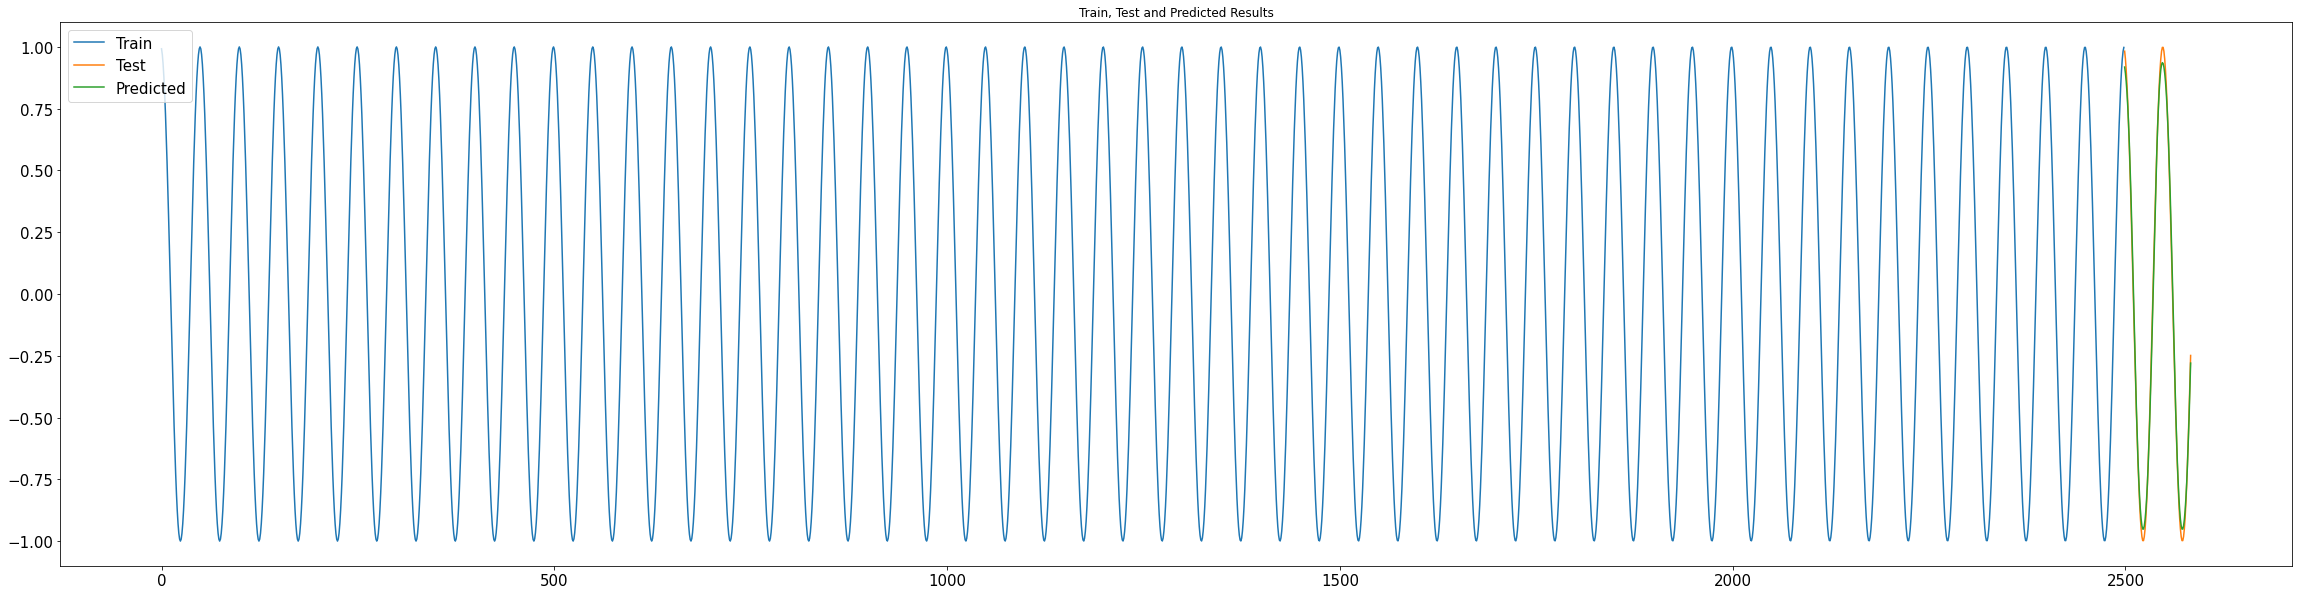

In [75]:
lstm(X_train_2, y_train_2, X_test_2, y_test_2, 10)

### 1.2.2. FTLFN Model

### 1.2.2.1. First split:

FTLFN Model contructed with 12 neurons:

Currently fitting the model with the training set with 10  epochs:
75/75 [==============================] - 0s 1ms/step - loss: 0.5005 - mean_absolute_error: 0.6367
Repeat 0) TrainMSE=0.498162, TestMSE=0.497645 

Currently fitting the model with the training set with 10  epochs:
75/75 [==============================] - 0s 1ms/step - loss: 0.5013 - mean_absolute_error: 0.6372
Repeat 1) TrainMSE=0.498841, TestMSE=0.497010 

Currently fitting the model with the training set with 10  epochs:
75/75 [==============================] - 0s 1ms/step - loss: 0.5004 - mean_absolute_error: 0.6367
Repeat 2) TrainMSE=0.497479, TestMSE=0.496610 

Currently fitting the model with the training set with 10  epochs:
75/75 [==============================] - 0s 1ms/step - loss: 0.5003 - mean_absolute_error: 0.6367
Repeat 3) TrainMSE=0.497500, TestMSE=0.496444 

Currently fitting the model with the training set with 10  epochs:
75/75 [==============================] -

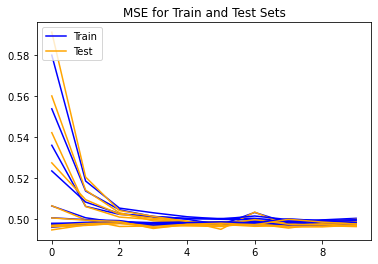

In [76]:
run_ftlfn(X_train_1, y_train_1, X_test_1, y_test_1, 10, 10)

### 1.2.2.2. Second split:

FTLFN Model contructed with 12 neurons:

Currently fitting the model with the training set with 10  epochs:
79/79 [==============================] - 0s 2ms/step - loss: 0.5003 - mean_absolute_error: 0.6367
Repeat 0) TrainMSE=0.498574, TestMSE=0.497833 

Currently fitting the model with the training set with 10  epochs:
79/79 [==============================] - 0s 1ms/step - loss: 0.5003 - mean_absolute_error: 0.6367
Repeat 1) TrainMSE=0.499111, TestMSE=0.498311 

Currently fitting the model with the training set with 10  epochs:
79/79 [==============================] - 0s 1ms/step - loss: 0.5006 - mean_absolute_error: 0.6370
Repeat 2) TrainMSE=0.497548, TestMSE=0.496774 

Currently fitting the model with the training set with 10  epochs:
79/79 [==============================] - 0s 2ms/step - loss: 0.5001 - mean_absolute_error: 0.6367
Repeat 3) TrainMSE=0.497594, TestMSE=0.496676 

Currently fitting the model with the training set with 10  epochs:
79/79 [==============================] -

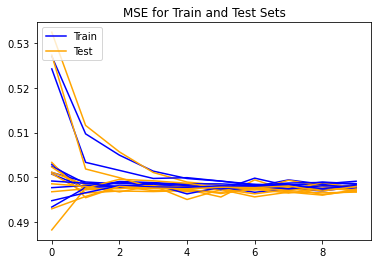

In [77]:
run_ftlfn(X_train_2, y_train_2, X_test_2, y_test_2, 10, 10)

### 1.3. Evaluating the performance of LSTM and FTLFN models with both splits and without noise


 
**LSTM Model - Set 1 Vs Set 2:** <p>
The obtained MSE results demonstrates that the set 2 have shown smaller MSE values as the leaning process increases (epochs) and made better predictions, compared with set 1.

<br>

**FTLFN Model - Set 1 Vs Set 2:** <p>
The set 1 as the learning process increases (epochs) the MSE showed a better stabilization in comparation with set 2. <p> 
Thus, set 1 showed to have a faster learning process and was able to train the both models in a better way, then set 2. 

<br>

**LSTM vs FTLFN Model:** <p>
In both sets, LSTM model showed smaller MSE values compared with FTLFN model.

<br>





### 1.3. Inferring the evolution of LSTM and FTLFN learning process with noise

### 1.3.1. LSTM Model

### 1.3.1.1. First split:

LSTM Model contructed with 3 hidden layers of 12 neurons:

Currently fitting the model with the training set with 10  epochs:
Epoch 1/10
75/75 [==============================] - 5s 9ms/step - loss: 0.3957 - mean_absolute_error: 0.5663
Epoch 2/10
75/75 [==============================] - 1s 9ms/step - loss: 0.1211 - mean_absolute_error: 0.2835
Epoch 3/10
75/75 [==============================] - 1s 8ms/step - loss: 0.0449 - mean_absolute_error: 0.1681
Epoch 4/10
75/75 [==============================] - 1s 8ms/step - loss: 0.0364 - mean_absolute_error: 0.1506
Epoch 5/10
75/75 [==============================] - 1s 8ms/step - loss: 0.0299 - mean_absolute_error: 0.1379
Epoch 6/10
75/75 [==============================] - 1s 9ms/step - loss: 0.0260 - mean_absolute_error: 0.1267
Epoch 7/10
75/75 [==============================] - 1s 9ms/step - loss: 0.0248 - mean_absolute_error: 0.1245
Epoch 8/10
75/75 [==============================] - 1s 8ms/step - loss: 0.0243 - mean_absolute_error: 0.1225
Ep

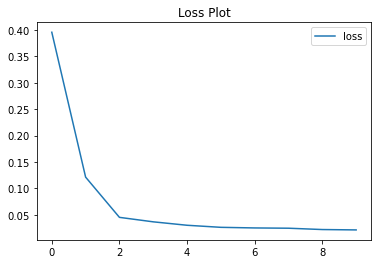

LSTM Model Test MSE: 0.001
LSTM Model Test RMSE: 0.025


c:\Users\raimu\anaconda3\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


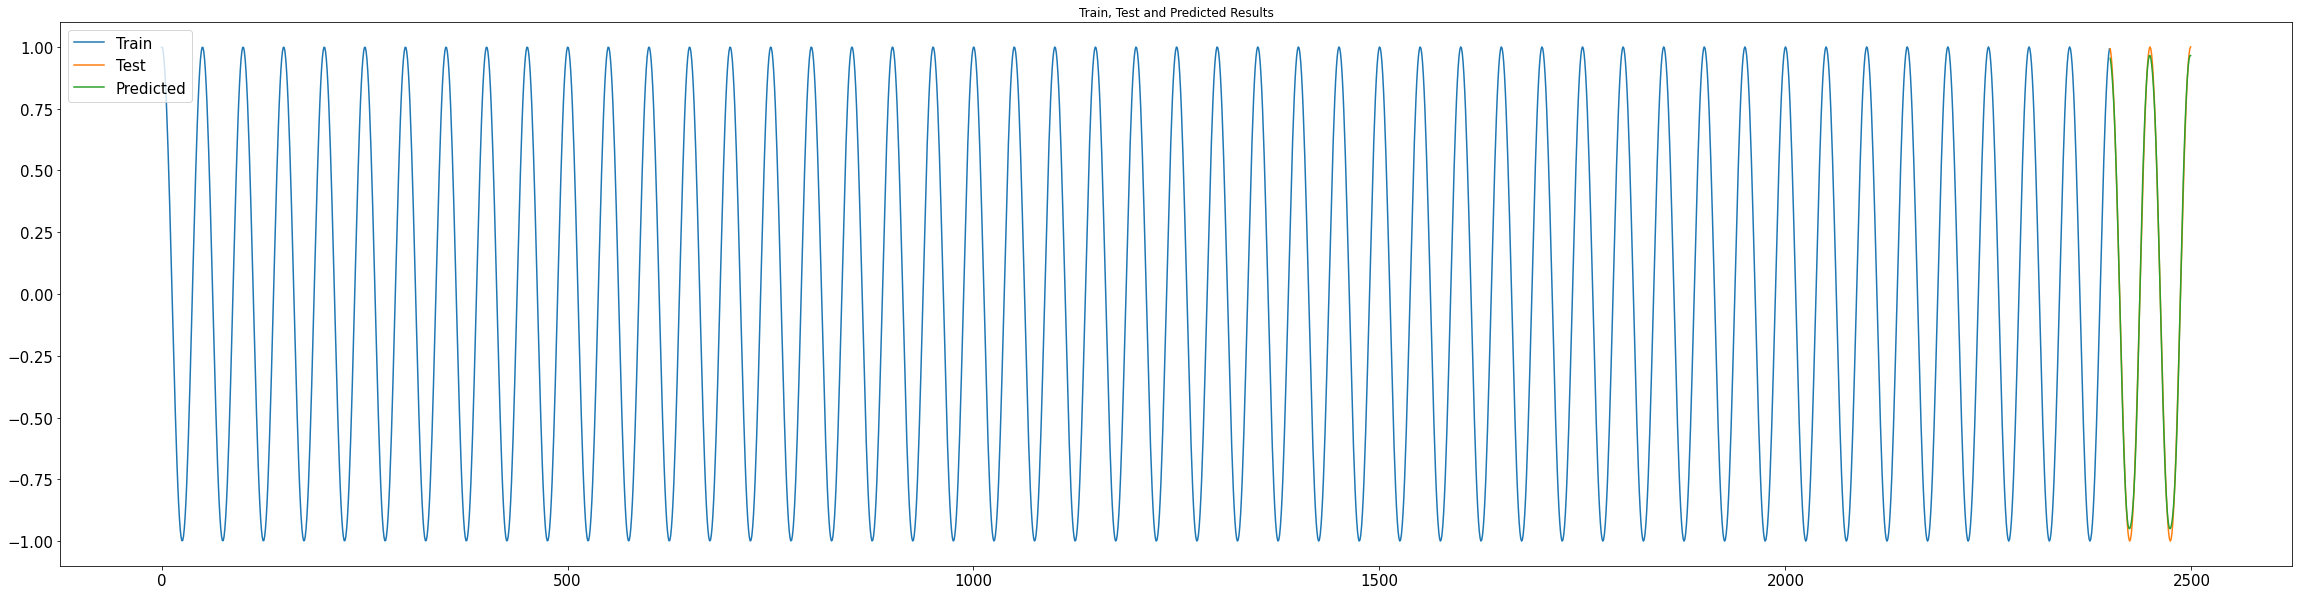

In [79]:
lstm(X_train_1, y_train_1, X_test_1, y_test_1, 10, True)

### 1.3.1.2. Second split:

LSTM Model contructed with 3 hidden layers of 12 neurons:

Currently fitting the model with the training set with 10  epochs:
Epoch 1/10
79/79 [==============================] - 6s 12ms/step - loss: 0.3399 - mean_absolute_error: 0.5230
Epoch 2/10
79/79 [==============================] - 1s 11ms/step - loss: 0.1115 - mean_absolute_error: 0.2738
Epoch 3/10
79/79 [==============================] - 1s 11ms/step - loss: 0.0376 - mean_absolute_error: 0.1530
Epoch 4/10
79/79 [==============================] - 1s 11ms/step - loss: 0.0325 - mean_absolute_error: 0.1417
Epoch 5/10
79/79 [==============================] - 1s 11ms/step - loss: 0.0275 - mean_absolute_error: 0.1301
Epoch 6/10
79/79 [==============================] - 1s 11ms/step - loss: 0.0249 - mean_absolute_error: 0.1238
Epoch 7/10
79/79 [==============================] - 1s 12ms/step - loss: 0.0233 - mean_absolute_error: 0.1194
Epoch 8/10
79/79 [==============================] - 1s 13ms/step - loss: 0.0228 - mean_absolute_error: 0

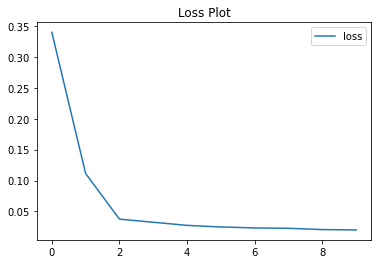

LSTM Model Test MSE: 0.002
LSTM Model Test RMSE: 0.043


c:\Users\raimu\anaconda3\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


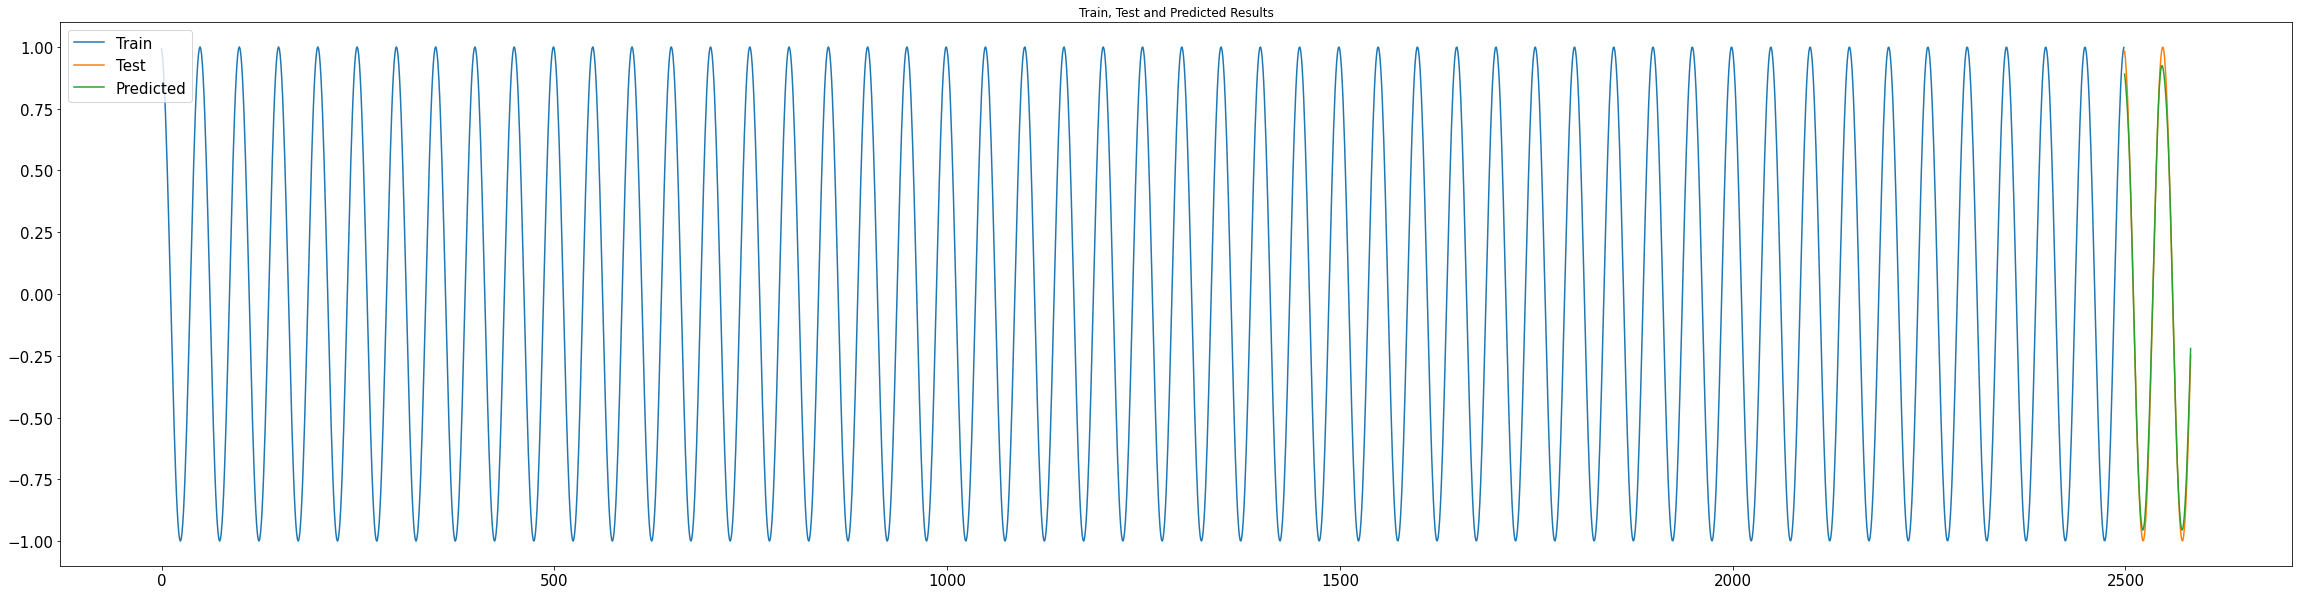

In [80]:
lstm(X_train_2, y_train_2, X_test_2, y_test_2, 10, True)

### 1.3.2. FTLFN Model

### 1.3.2.1. First Split:

FTLFN Model contructed with 12 neurons:

Currently fitting the model with the training set with 10  epochs:
75/75 [==============================] - 0s 1ms/step - loss: 0.5006 - mean_absolute_error: 0.6367
Repeat 0) TrainMSE=0.498240, TestMSE=0.497914 

Currently fitting the model with the training set with 10  epochs:
75/75 [==============================] - 0s 1ms/step - loss: 0.5000 - mean_absolute_error: 0.6362
Repeat 1) TrainMSE=0.496610, TestMSE=0.494833 

Currently fitting the model with the training set with 10  epochs:
75/75 [==============================] - 0s 1ms/step - loss: 0.5001 - mean_absolute_error: 0.6363
Repeat 2) TrainMSE=0.501289, TestMSE=0.501792 

Currently fitting the model with the training set with 10  epochs:
75/75 [==============================] - 0s 1ms/step - loss: 0.5003 - mean_absolute_error: 0.6366
Repeat 3) TrainMSE=0.501087, TestMSE=0.501406 

Currently fitting the model with the training set with 10  epochs:
75/75 [==============================] -

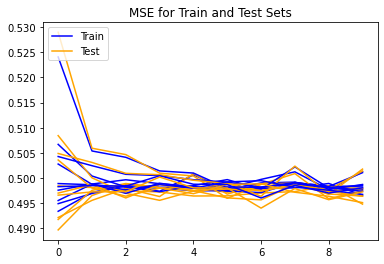

In [81]:
run_ftlfn(X_train_1, y_train_1, X_test_1, y_test_1, 10, 10, True)

### 1.3.2.2. Second Split

FTLFN Model contructed with 12 neurons:

Currently fitting the model with the training set with 10  epochs:
79/79 [==============================] - 0s 1ms/step - loss: 0.5012 - mean_absolute_error: 0.6371
Repeat 0) TrainMSE=0.499043, TestMSE=0.497933 

Currently fitting the model with the training set with 10  epochs:
79/79 [==============================] - 0s 2ms/step - loss: 0.4999 - mean_absolute_error: 0.6365
Repeat 1) TrainMSE=0.497775, TestMSE=0.497139 

Currently fitting the model with the training set with 10  epochs:
79/79 [==============================] - 0s 2ms/step - loss: 0.5001 - mean_absolute_error: 0.6365
Repeat 2) TrainMSE=0.497503, TestMSE=0.496939 

Currently fitting the model with the training set with 10  epochs:
79/79 [==============================] - 0s 1ms/step - loss: 0.5001 - mean_absolute_error: 0.6365
Repeat 3) TrainMSE=0.496190, TestMSE=0.494326 

Currently fitting the model with the training set with 10  epochs:
79/79 [==============================] -

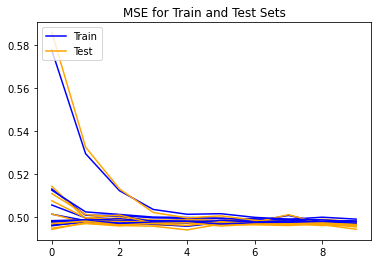

In [82]:
run_ftlfn(X_train_2, y_train_2, X_test_2, y_test_2, 10, 10, True)

### 1.3.3. Evaluating the performance of LSTM and FTLFN models with both splits and with noise


 
**LSTM Model - Set 1 Vs Set 2:** <p>
The obtained MSE results demonstrates that the set 1 have shown smaller MSE values as the leaning process increases (epochs) and made better predictions, compared with set 2.

<br>

**FTLFN Model - Set 1 Vs Set 2:** <p>
The set 2 as the learning process increases (epochs) the MSE showed a better stabilization in comparation with set 1. <p> 
Thus, set 2 showed to have a faster learning process and was able to train the both models in a better way, then set 1. 

<br>

**LSTM vs FTLFN Model:** <p>
In both sets, LSTM model showed smaller MSE values compared with FTLFN model.

<br>


## Problem 2

We defined a time series using the output of the following autoregression model with a time delay of 12, generating 5000 data points.

**Autoregression model:**<p>

![](autoregression_model.JPG)

α1 = 0.6, α2= -0.54, α3= -0.44 <p>

We subset the timeseries dataset in two distinct manners, in order to evaluate the performances when performed with each model (LSTM and FTLFN) with:
 * Gaussin Noise N(0,0.01)
 * 50 epochs
 
<p>

**Splits:**
  * The first 2400 data points and test with data points 2401 to 2500
  * Data points 2401 to 4900 and test with data points 4901 to 5000

### 2.1. Creation of a time series:

In [83]:
data = [5,6,3]

for i in range(4997):
    out = (0.6*data[i+2]) + (-0.54*data[i+1]) + (-0.44*data[i]) #+ 0.01 (U)
    data.append(out)

print(len(data))

5000


Adding a filter (time delay) of 12 to the time series:

In [84]:
X = []
y = []
lag = 12

for i in range(lag, 4999):
   X.append(data[i-lag:i])
   y.append(data[i])

X = np.expand_dims(X, axis = 2)
y = np.array(y)

Split Data:

- Training with the first 2400 data points and testing with data points 2401 to 2501 (First split);
  
- Training from data points 2401 to 4900 and testing with data points 4901 to the last data point (Second split).

In [85]:
X_train_1 = X[:2400]
y_train_1 = y[:2400]
X_test_1  = X[2401:2501]
y_test_1  = y[2401:2501]

X_train_2 = X[2401:4900]
y_train_2 = y[2401:4900]
X_test_2  = X[4901:-1]
y_test_2  = y[4901:-1]

print("Shape of sets: \n")
print("--> First Split Train and Test sets:")
print("X_train_1: ", X_train_1.shape)
print("y_train_1: ", y_train_1.shape)
print("X_test_1: ", X_test_1.shape)
print("y_test_1: ", y_test_1.shape,"\n")

print("--> Second Split Train and Test sets:")
print("X_train_2: ", X_train_2.shape)
print("y_train_2: ", y_train_2.shape)
print("X_test_2: ", X_test_2.shape)
print("y_test_2: ", y_test_2.shape)

Shape of sets: 

--> First Split Train and Test sets:
X_train_1:  (2400, 12, 1)
y_train_1:  (2400,)
X_test_1:  (100, 12, 1)
y_test_1:  (100,) 

--> Second Split Train and Test sets:
X_train_2:  (2499, 12, 1)
y_train_2:  (2499,)
X_test_2:  (85, 12, 1)
y_test_2:  (85,)


### 2.2. Inferring the evolution of LSTM and FTLFN learning process with noise

### 2.2.1. LSTM Model 

### 2.2.1.1. First split:

LSTM Model contructed with 3 hidden layers of 12 neurons:

Currently fitting the model with the training set with 50  epochs:
Epoch 1/50
75/75 [==============================] - 5s 9ms/step - loss: 5.7119 - mean_absolute_error: 1.9294
Epoch 2/50
75/75 [==============================] - 1s 8ms/step - loss: 4.3978 - mean_absolute_error: 1.6908
Epoch 3/50
75/75 [==============================] - 1s 8ms/step - loss: 2.3670 - mean_absolute_error: 1.1882
Epoch 4/50
75/75 [==============================] - 1s 8ms/step - loss: 1.4797 - mean_absolute_error: 0.9230
Epoch 5/50
75/75 [==============================] - 1s 9ms/step - loss: 1.1645 - mean_absolute_error: 0.8138
Epoch 6/50
75/75 [==============================] - 1s 8ms/step - loss: 0.8975 - mean_absolute_error: 0.7030
Epoch 7/50
75/75 [==============================] - 1s 8ms/step - loss: 0.8319 - mean_absolute_error: 0.6687
Epoch 8/50
75/75 [==============================] - 1s 8ms/step - loss: 0.6745 - mean_absolute_error: 0.6023
Ep

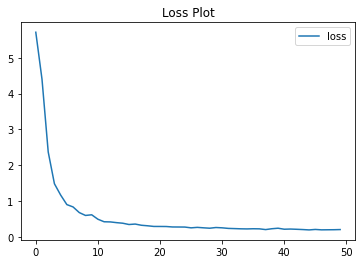

LSTM Model Test MSE: 0.003
LSTM Model Test RMSE: 0.056


c:\Users\raimu\anaconda3\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


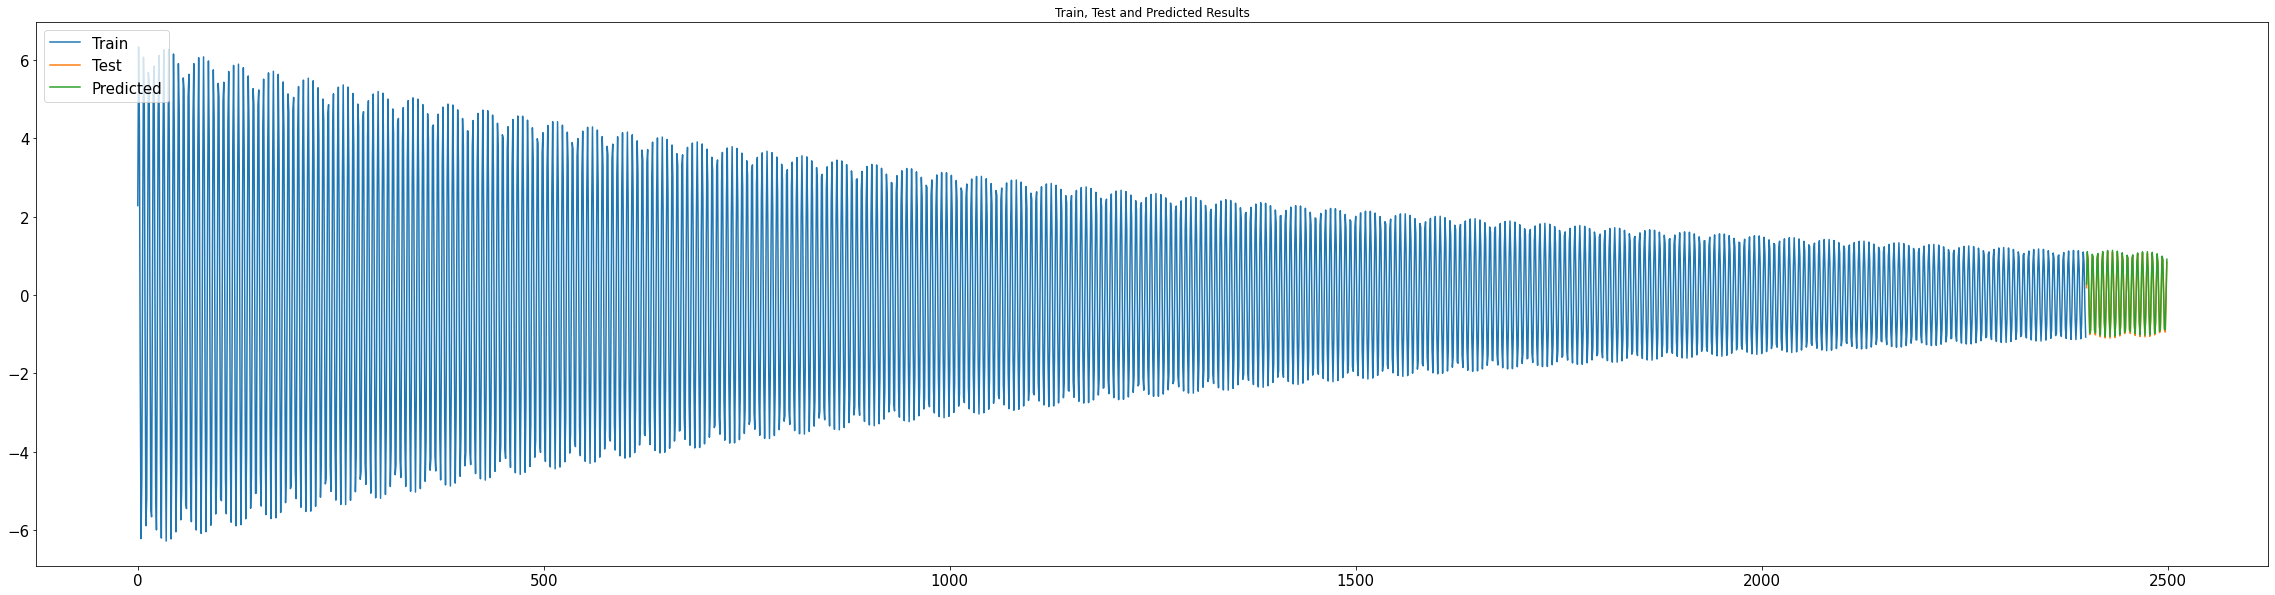

In [86]:
lstm(X_train_1, y_train_1, X_test_1, y_test_1, 50, True, 0.01)

### 2.2.1.1. Second split:

LSTM Model contructed with 3 hidden layers of 12 neurons:

Currently fitting the model with the training set with 50  epochs:
Epoch 1/50
79/79 [==============================] - 6s 12ms/step - loss: 0.1596 - mean_absolute_error: 0.3199
Epoch 2/50
79/79 [==============================] - 1s 12ms/step - loss: 0.0971 - mean_absolute_error: 0.2425
Epoch 3/50
79/79 [==============================] - 1s 12ms/step - loss: 0.0499 - mean_absolute_error: 0.1689
Epoch 4/50
79/79 [==============================] - 1s 12ms/step - loss: 0.0372 - mean_absolute_error: 0.1425
Epoch 5/50
79/79 [==============================] - 1s 12ms/step - loss: 0.0328 - mean_absolute_error: 0.1356
Epoch 6/50
79/79 [==============================] - 1s 13ms/step - loss: 0.0281 - mean_absolute_error: 0.1251
Epoch 7/50
79/79 [==============================] - 1s 12ms/step - loss: 0.0262 - mean_absolute_error: 0.1205
Epoch 8/50
79/79 [==============================] - 1s 12ms/step - loss: 0.0237 - mean_absolute_error: 0

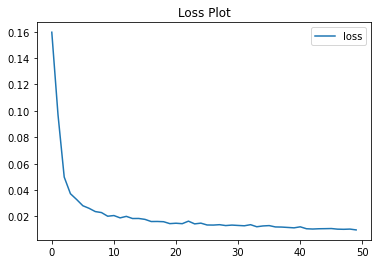

LSTM Model Test MSE: 0.001
LSTM Model Test RMSE: 0.023


c:\Users\raimu\anaconda3\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


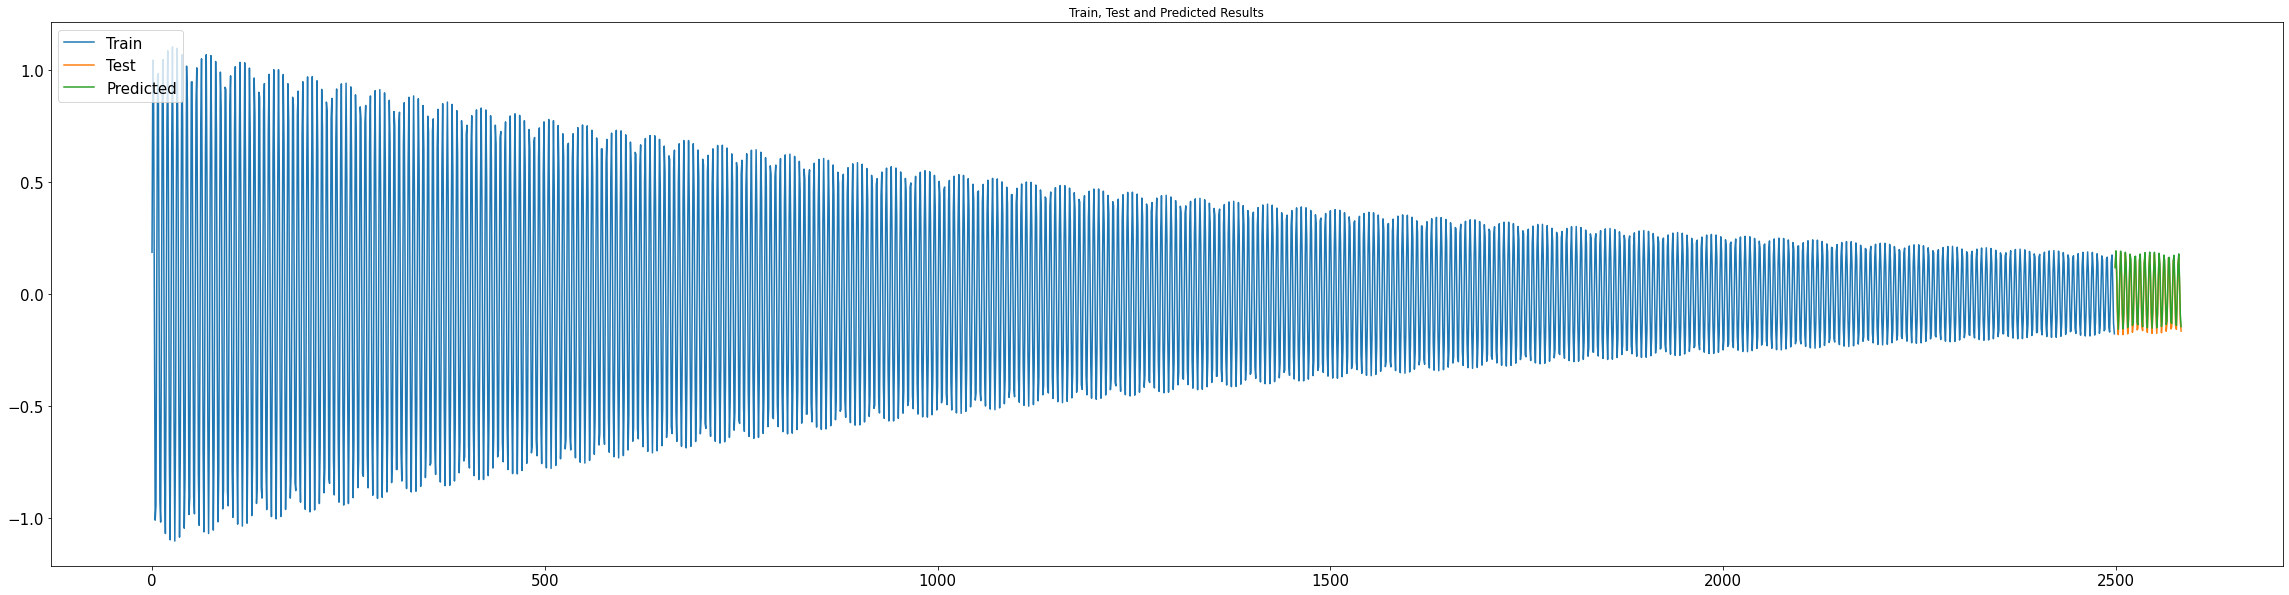

In [87]:
lstm(X_train_2, y_train_2, X_test_2, y_test_2, 50, True, 0.01)

### 2.2.2. FTLFN Model 

### 2.2.2.1. First split:

FTLFN Model contructed with 12 neurons:

Currently fitting the model with the training set with 50  epochs:
75/75 [==============================] - 0s 1ms/step - loss: 5.7865 - mean_absolute_error: 1.9430
Repeat 0) TrainMSE=5.782724, TestMSE=0.587749 

Currently fitting the model with the training set with 50  epochs:
75/75 [==============================] - 0s 1ms/step - loss: 5.7843 - mean_absolute_error: 1.9431
Repeat 1) TrainMSE=5.782909, TestMSE=0.587681 

Currently fitting the model with the training set with 50  epochs:
75/75 [==============================] - 0s 1ms/step - loss: 5.7845 - mean_absolute_error: 1.9430
Repeat 2) TrainMSE=5.782929, TestMSE=0.587647 

Currently fitting the model with the training set with 50  epochs:
75/75 [==============================] - 0s 1ms/step - loss: 5.7863 - mean_absolute_error: 1.9433
Repeat 3) TrainMSE=5.784060, TestMSE=0.588291 

Currently fitting the model with the training set with 50  epochs:
75/75 [==============================] -

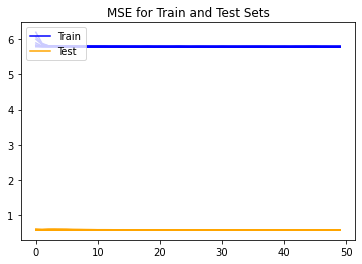

In [88]:
run_ftlfn(X_train_1, y_train_1, X_test_1, y_test_1,10, 50, True, 0.01)

### 2.2.2.2. Second split:

FTLFN Model contructed with 12 neurons:

Currently fitting the model with the training set with 50  epochs:
79/79 [==============================] - 0s 1ms/step - loss: 0.1702 - mean_absolute_error: 0.3306
Repeat 0) TrainMSE=0.170163, TestMSE=0.588061 

Currently fitting the model with the training set with 50  epochs:
79/79 [==============================] - 0s 2ms/step - loss: 0.1703 - mean_absolute_error: 0.3307
Repeat 1) TrainMSE=0.170187, TestMSE=0.587691 

Currently fitting the model with the training set with 50  epochs:
79/79 [==============================] - 0s 1ms/step - loss: 0.1703 - mean_absolute_error: 0.3307
Repeat 2) TrainMSE=0.170120, TestMSE=0.587938 

Currently fitting the model with the training set with 50  epochs:
79/79 [==============================] - 0s 2ms/step - loss: 0.1704 - mean_absolute_error: 0.3308
Repeat 3) TrainMSE=0.170097, TestMSE=0.587754 

Currently fitting the model with the training set with 50  epochs:
79/79 [==============================] -

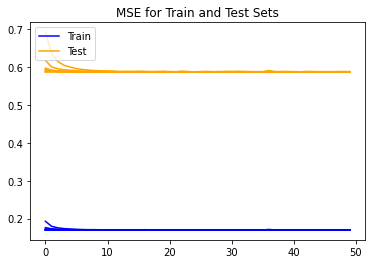

In [89]:
run_ftlfn(X_train_2, y_train_2, X_test_2, y_test_2,10, 50, True, 0.01)

### 2.3. Evaluating the performance of LSTM and FTLFN models with both splits and with noise

 **LSTM Model - Set 1 Vs Set 2:** <p>
The obtained MSE results demonstrates that the set 2 have shown smaller MSE values as the leaning process increases (epochs), however made worse predictions, compared with set 1.

<br>

**FTLFN Model - Set 1 Vs Set 2:** <p>
The training and test MSE obtained results for the set 2, showed to be smaller compared with set 1.

<br>

**LSTM vs FTLFN Model:** <p>
In both sets, LSTM model showed smaller MSE values compared with FTLFN model.

<br>